In [14]:
import torch
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
import scipy.io
import h5py
import torch.utils.data as Data
import time
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = 'deepsea_train/'

### Data exploration

In [3]:
## VALIDATION DATA ###
valid_data_raw = scipy.io.loadmat(DATA_PATH+'valid.mat')
x_valid = torch.FloatTensor(valid_data_raw['validxdata'])
y_valid = torch.FloatTensor(valid_data_raw['validdata'])

Each training sample consists of a 1,000-bp sequence from the human GRCh37 reference genome centered on each 200-bp bin and is paired with a label vector for 919 chromatin features. 

The 1,000-bp DNA sequence is represented by a 1,000 × 4 binary matrix, with columns corresponding to A, G, C and T.

# Deep Sea

In [4]:
nfeats = 4
height = 1
nkernels = [320,480,960]
dropouts = [0.2,0.5]

In [5]:
class deep_sea_nn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=nfeats,      out_channels=nkernels[0], kernel_size=8)
        self.conv2 = nn.Conv1d(in_channels=nkernels[0], out_channels=nkernels[1], kernel_size=8)
        self.conv3 = nn.Conv1d(in_channels=nkernels[1], out_channels=nkernels[2], kernel_size=8)
        self.maxpool = nn.MaxPool1d(kernel_size=4, stride=4)
        self.drop1 = nn.Dropout(p=dropouts[0])
        self.drop2 = nn.Dropout(p=dropouts[1])
        self.linear1 = nn.Linear(53*960, 925)
        self.linear2 = nn.Linear(925, 919)
    
    def foward(self, input):
        ## convolution 1 ##
        ds = self.conv1(input)
        ds = F.relu(ds)
        ds = self.maxpool(ds)
        ds = self.drop1(ds)
        
        ## convolution 2 ##
        ds = self.conv2(ds)
        ds = F.relu(ds)
        ds = self.maxpool(ds)
        ds = self.drop1(ds)
        
        ## convolution 3 ##
        ds = self.conv3(ds)
        ds = F.relu(ds)
        ds = self.drop2(ds)
        
        ds = ds.view(-1, 53*960)
        ds = self.linear1(ds)
        ds = F.relu(ds)
        ds = self.linear2(ds)
        
        return ds
        

In [6]:
## HYPERPARMETERS
params = {'batch_size': 100,'num_workers': 2}
device = 'cuda'

learning_rate = 0.01
batch_size = 100
epochs = 10

In [7]:
deep_sea = deep_sea_nn()
deep_sea.to(device)
print(deep_sea)

optimizer = optim.SGD(deep_sea.parameters(), lr=learning_rate,momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5,verbose=1)
loss_func = nn.BCEWithLogitsLoss()

deep_sea_nn(
  (conv1): Conv1d(4, 320, kernel_size=(8,), stride=(1,))
  (conv2): Conv1d(320, 480, kernel_size=(8,), stride=(1,))
  (conv3): Conv1d(480, 960, kernel_size=(8,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.2)
  (drop2): Dropout(p=0.5)
  (linear1): Linear(in_features=50880, out_features=925, bias=True)
  (linear2): Linear(in_features=925, out_features=919, bias=True)
)


In [8]:
valid_loader = Data.DataLoader(dataset=Data.TensorDataset(x_valid, y_valid), shuffle=False,**params)

In [9]:
train_losses, valid_losses = [], []
running_loss = 0
running_val_loss = 0

start_time = time.time()
for epoch in range(epochs):
    running_loss = 0
    deep_sea.train()
    ### for each part of the training set ###
    for i in range(0,10):
        x_train_part = torch.FloatTensor(np.load(DATA_PATH+"x_train_part_{}.npy".format(i)))
        y_train_part = torch.FloatTensor(np.load(DATA_PATH+"y_train_part_{}.npy".format(i)))
        
        train_loader = Data.DataLoader(dataset=Data.TensorDataset(x_train_part, y_train_part), shuffle=True, **params)
        print(f"#### Training Epoch {epoch+1}/{epochs}.. "
              f"Training data Part: {i}.. ")
        
        part_start_time = time.time()
        for j, (inputs, labels) in enumerate(train_loader):

            
            x, y = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            out = deep_sea.foward(x)
            loss = loss_func(out.to(device), y)
            loss.backward()
            optimizer.step()
            
            running_loss = loss.item()
            train_losses.append(running_loss)
            
        part_time_elapsed = time.time() - part_start_time
        print('#### Training part time elapsed:', part_time_elapsed)
        
    if (epoch+1) % 5 == 0:
        torch.save(deep_sea, 'deep_sea_model_training_epoch_{e}.pth'.format(e=epoch+1))
        torch.save(deep_sea.state_dict(), 'deep_sea_model_training_epoch_{e}_params.pth'.format(e=epoch+1))
            
    ## Validation ##
    running_val_loss = 0
    for i, (inputs, labels) in enumerate(valid_loader):
        deep_sea.eval()
        with torch.no_grad():
            x, y = inputs.to(device), labels.to(device)

            val_out = deep_sea.foward(x)
            val_loss = loss_func(val_out, y)

            running_val_loss = val_loss.item()
            valid_losses.append(running_val_loss)

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {running_loss}.. "
          f"Validation loss: {running_val_loss}.. ")
    
            
time_elapsed = time.time() - start_time
print('#### Training time :', time_elapsed)

torch.save(deep_sea, 'deep_sea_model.pth')
torch.save(deep_sea.state_dict(), 'deep_sea_model_params.pth'.format(epoch))

#### Training Epoch 1/10.. Training data Part: 0.. 
#### Training part time elapsed: 197.79401326179504
#### Training Epoch 1/10.. Training data Part: 1.. 
#### Training part time elapsed: 196.35107254981995
#### Training Epoch 1/10.. Training data Part: 2.. 
#### Training part time elapsed: 190.28271985054016
#### Training Epoch 1/10.. Training data Part: 3.. 
#### Training part time elapsed: 190.31472516059875
#### Training Epoch 1/10.. Training data Part: 4.. 
#### Training part time elapsed: 190.23392343521118
#### Training Epoch 1/10.. Training data Part: 5.. 
#### Training part time elapsed: 190.38456225395203
#### Training Epoch 1/10.. Training data Part: 6.. 
#### Training part time elapsed: 190.350346326828
#### Training Epoch 1/10.. Training data Part: 7.. 
#### Training part time elapsed: 190.38146138191223
#### Training Epoch 1/10.. Training data Part: 8.. 
#### Training part time elapsed: 191.61573696136475
#### Training Epoch 1/10.. Training data Part: 9.. 
#### Training 

/home/erick/anaconda3/envs/secure_private_ai/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type deep_sea_nn. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 1/10.. Train loss: 0.09881587326526642.. Validation loss: 0.08267591148614883.. 
#### Training Epoch 2/10.. Training data Part: 0.. 
#### Training part time elapsed: 190.67163372039795
#### Training Epoch 2/10.. Training data Part: 1.. 
#### Training part time elapsed: 194.55890226364136
#### Training Epoch 2/10.. Training data Part: 2.. 
#### Training part time elapsed: 193.54051995277405
#### Training Epoch 2/10.. Training data Part: 3.. 
#### Training part time elapsed: 192.52011895179749
#### Training Epoch 2/10.. Training data Part: 4.. 
#### Training part time elapsed: 192.25975799560547
#### Training Epoch 2/10.. Training data Part: 5.. 
#### Training part time elapsed: 192.20218181610107
#### Training Epoch 2/10.. Training data Part: 6.. 
#### Training part time elapsed: 192.2119061946869
#### Training Epoch 2/10.. Training data Part: 7.. 
#### Training part time elapsed: 192.29465055465698
#### Training Epoch 2/10.. Training data Part: 8.. 
#### Training part time elapse

In [19]:
21231.245/3600

5.897568055555555

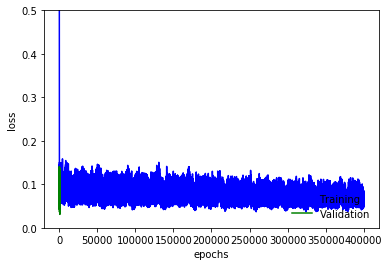

In [17]:
plt.plot(np.arange(0,len(train_losses)), train_losses,'-b', label='Training')
plt.plot(np.arange(0,len(valid_losses)), valid_losses,'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(top = 0.5, bottom = 0.0)
plt.ylabel('loss')
plt.xlabel('epochs');